In [46]:
%pylab inline
import glob
import numpy as np
import sys
import seaborn as sns
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
PLOTDIR = '/storage/BonnieH/selection_project/joint_method/figures/validation_one_opt/plot_together/'

Populating the interactive namespace from numpy and matplotlib


In [47]:
# PLot cdf of gamma distribution posterior estimates for real data

def main():
    print('Running main')
    
    folder = 't23'
    pers = [2,3,4] 
    #color_list = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','b','k']
    color_list = ['red','orange','gold','lawngreen','forestgreen','turquoise','blue','purple','brown','slategray']
    
    motif_dic = {}
    motif_dic[2] = ['0.0']
    motif_dic[3] = ['0.0','1.0']
    motif_dic[4] = ['0.0']
    
    opt_dic = {}
    opt_dic[2] = range(11,21,1)
    opt_dic[3] = range(5,14,1)
    opt_dic[4] = range(7,11,1)
    #clrs = sns.color_palette('husl', n_colors=10)
    
    # Plot 
    # Plot each period separately
    color_dic_opt={}
    for per in pers:
        i = -1
        for opt in opt_dic[per]:
            i = i + 1
            color_dic_opt[(per, opt)] = color_list[i]
    color_dic = {}
    color_dic[('2', '0.0')] = 'C0'
    color_dic[('3', '0.0')] = 'C1'
    color_dic[('3', '1.0')] = 'C2'
    color_dic[('4', '0.0')] = 'C3'
    
    bins_list = [0]
    exponents = [10**-5, 10**-4, 10**-3, 10**-2]
    for j in exponents:
        for i in np.arange(1,10,0.01):
            bins_list.append(i*j)

    bins_list.append(0.1)
    bins_list.append(1)
    
    # Plot noncoding v coding loci
    file_list = glob.glob('./results/results/%s/per_*_7_*.txt'%(folder))
    file_list.sort() 
    base_plot = ''
    cum_dic = {}
    for filename in file_list:
        per = filename[26]
        results_file = open(filename, 'r')
        lines = results_file.readlines()
        line = lines[9]
        info = line.strip().split(': ')
        num_acc = int(info[1])
        line = lines[1]
        info = line.strip().split(': ')
        num_loci = int(info[1])
        if num_acc > 0 and num_loci >= 10:
            line = lines[2]
            info = line.strip().split(': ')
            motif = info[2]
            motif = motif.strip().split(' ')
            motif = motif[0]
            opt_allele = info[3]
            line = lines[11]
            info = line.strip().split(',')
            k = float(info[0])
            theta = float(info[1])

            s = [] # List of s values drawn from gamma distribution
            num_sims = 10000
            for i in range(0, num_sims):
                s_val = np.random.gamma(k, theta)
                if s_val > 0.1:
                    s_val = 0.1

                s.append(s_val)
                    
            values, base = np.histogram(s, bins=bins_list)# [0,10**-5,10**-4,10**-3,10**-2,10**-1,1]#[0,10**-5,10**-4,10**-3,10**-2,10**-1,1]
                    
            cumulative = list(np.cumsum(values))
            maximum = max(cumulative)
            cumulative_scaled = []
            for elem in cumulative:
                elem = elem/maximum
                cumulative_scaled.append(elem)
            
            cum_dic[(per, motif, opt_allele)] = cumulative_scaled
            base_plot = base
    
    cum_dic_per_locus = {}    
    for per in pers:
        opt_alleles = opt_dic[per]
        
        for opt in opt_alleles:
            for motif in motif_dic[per]:
                print(per,opt,motif)

                inFile = '/storage/BonnieH/selection_project/per_locus/SISTR_results/0.005_3_0.3_yny5_eurodem_prior2_all_per_0810.txt'
                allele_freqs_file = open(inFile, 'r')

                header = allele_freqs_file.readline().strip()
                s_per_locus = []
                for line in allele_freqs_file:
                    info = line.strip().split('\t')
                    period = int(info[4])
                    mot = info[7]
                    opt_allele = int(info[5])
                    total = int(info[3])
                    s_ABC = info[17]
                    if period == per and mot == motif and opt == opt_allele and total > 5214:
                        
                        if s_ABC != 'N/A':
                            s_ABC = float(s_ABC)
                            s_per_locus.append(s_ABC)
                            
                allele_freqs_file.close()
                vals, base = np.histogram(s_per_locus, bins=bins_list) # [0,10**-5,10**-4,10**-3,10**-2,10**-1,1]#[0,10**-5,10**-4,10**-3,10**-2,10**-1,1]
                        
                cumul = list(np.cumsum(vals))
                maximum = max(cumul)
                cumul_scaled = []
                for elem in cumul:
                    elem = elem/maximum
                    cumul_scaled.append(elem)
                        
                cum_dic_per_locus[(str(per), motif, str(opt))] = cumul_scaled
    
    subplots_list = [221,222,223,224]
    to_plots = [('2', '0.0'), ('3', '0.0') , ('3', '1.0'), ('4','0.0')]
    
    fig = plt.figure(figsize=(14,10))
    subplot_index = -1
    for to_plot in to_plots:
        subplot_index = subplot_index + 1
        ax = fig.add_subplot(subplots_list[subplot_index])
        
        i = -1
        for elem in cum_dic:
            
            if elem[0] == to_plot[0] and elem[1] == to_plot[1]:

                
                if elem[1] == '1.0':
                    lab = 'coding'
                else:
                    lab = 'noncoding'
                if elem[2] != '0':
                    i = i + 1
                    print(i)
                    ax.plot(base_plot[:-1], cum_dic[elem], label = 'Joint Opt ' + str(elem[2]), color=color_dic_opt[(int(elem[0]), int(elem[2]))], linewidth = 2, ls='dashed') #color_dic[(elem[0], elem[1])] color_list[i]
                    ax.plot(base_plot[:-1], cum_dic_per_locus[elem], label = 'Per-locus Opt ' + str(elem[2]), color=color_dic_opt[(int(elem[0]), int(elem[2]))], linewidth = 2) #color_dic[(elem[0], elem[1])] color_list[i]

        ax.set_xlim(10**-5, 0.1)
        ax.set_xscale('log')
        ax.set_title('Distribution of s values: per-locus v. joint method\n' + 'Per ' + to_plot[0] + ' ' + lab)
        ax.set_xlabel('s')
        ax.legend(bbox_to_anchor=(1.01, 1.01))
        ax.set_ylabel('Cumulative Frequency')
    fig.tight_layout()
    print('Done')

Running main
2 11 0.0
2 12 0.0
2 13 0.0
2 14 0.0
2 15 0.0
2 16 0.0
2 17 0.0
2 18 0.0
2 19 0.0
2 20 0.0
3 5 0.0
3 5 1.0
3 6 0.0
3 6 1.0
3 7 0.0
3 7 1.0
3 8 0.0
3 8 1.0
3 9 0.0
3 9 1.0
3 10 0.0
3 10 1.0
3 11 0.0
3 11 1.0
3 12 0.0
3 12 1.0
3 13 0.0
3 13 1.0
4 7 0.0
4 8 0.0
4 9 0.0
4 10 0.0
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
0
1
2
Done
CPU times: user 12.4 s, sys: 464 ms, total: 12.8 s
Wall time: 12.7 s


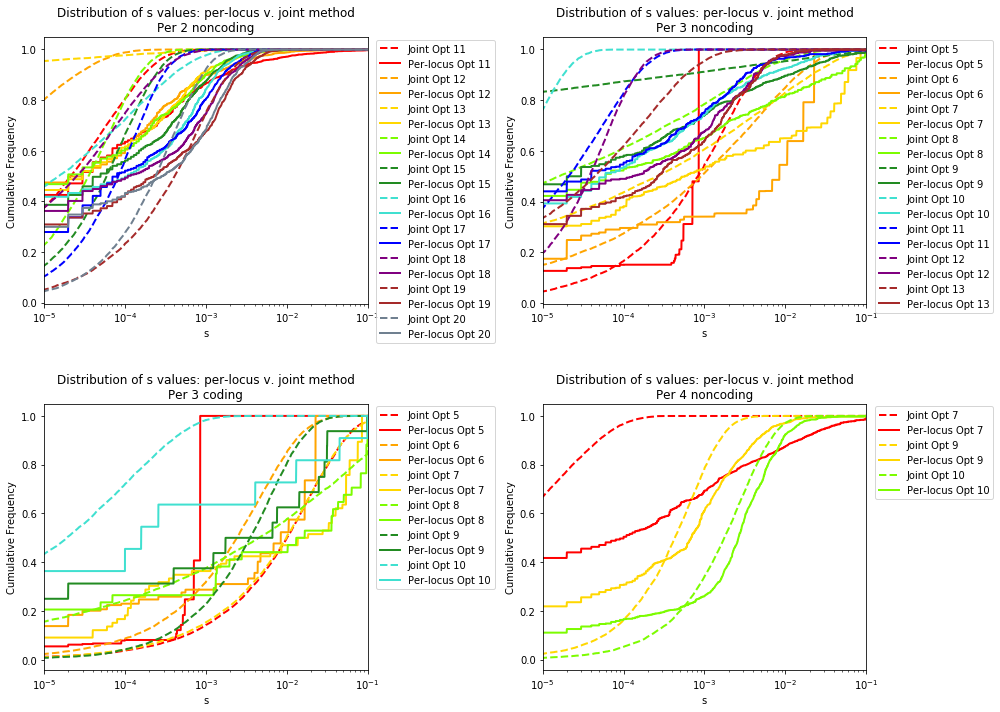

In [48]:
%%time
if __name__ == '__main__':
    main()